![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# Nubes de palabras del discurso del presidente Andrés Manuel López Obrador en el Consejo de Seguridad de la Organización de las Naciones Unidas

**Julio Waissman**

noviembre, 2021


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from bs4 import BeautifulSoup
import requests
import wordcloud

nlp = spacy.load('es_core_news_md')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)


## Descargando el texto

Vamos a usar `requests` para descargar la página completa como datos crudos, y luego utilizaremos `BeautifulSoup` para extraer del archivo el texto en parágrafor. Cáda parágrafo lo vamos a guardar en una entrada de un `dataframe`, por si luego decidimos hacer otro tipo de análisis con la información.


In [ ]:
url = "https://lopezobrador.org.mx/2021/11/09/discurso-del-presidente-andres-manuel-lopez-obrador-en-el-consejo-de-seguridad-de-la-organizacion-de-las-naciones-unidas/"

discurso_html = requests.get(url)
sopa = BeautifulSoup(discurso_html.text)

contenido = sopa.find_all("div", {"class":"entry-content"})
df = pd.DataFrame({
    'Parrafo': [parrafo.text for parrafo in contenido[0].find_all("p")] 
})

# Quitamos lineas sin texto
df = df[df.Parrafo.str.contains(r"\w", regex=True)]

## Haciendo una nube de palabras *rápido y furioso*

Ahora vamos autilizar el texto tal cual lo tenemos para hacer una nube de palabras, usando solo lo que nos ofrece la biblioteca de [`wordcloud`](https://amueller.github.io/word_cloud).



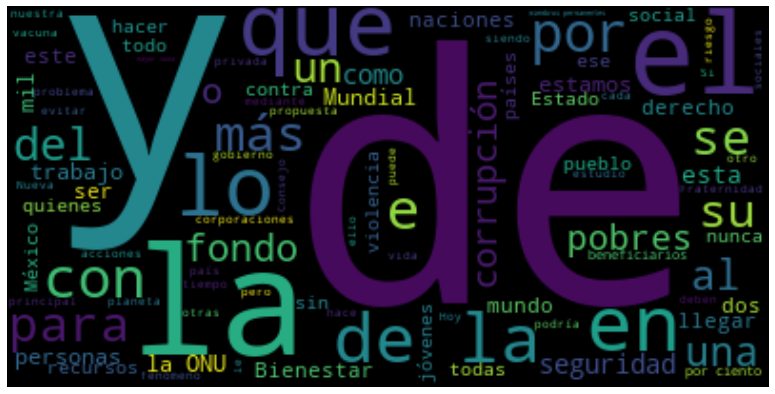

In [13]:
texto = '\n'.join(df.Parrafo.values)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Pues muy bonita pero muy inutil. El problema más grande de esta nube de palabras es que se hizo tomando en cuenta todas las palabras, y la mayoría de las que más se repiten no dan información.

Vamos entonces a usar la serie de palabras de paro que nos da `spacy` con el modelo en español que bajamos.

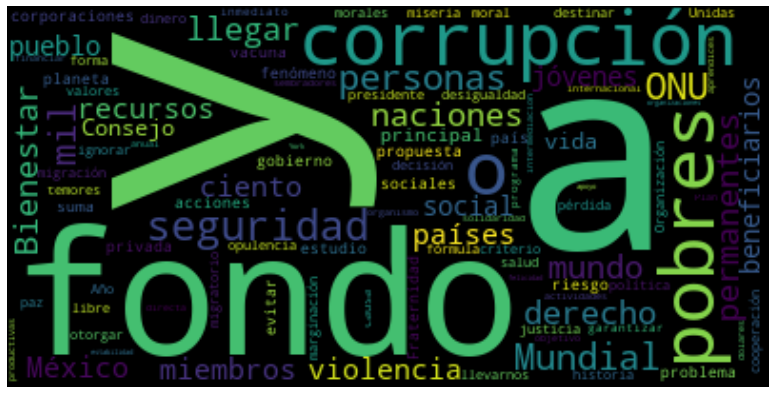

In [14]:
palabras_paro = nlp.Defaults.stop_words

# Genera la nube de palabras
wc = wordcloud.WordCloud(
    stopwords=palabras_paro
).generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Y pues algo mejor, pero vemos que se siguen usando palabras que deberían ser de paro.

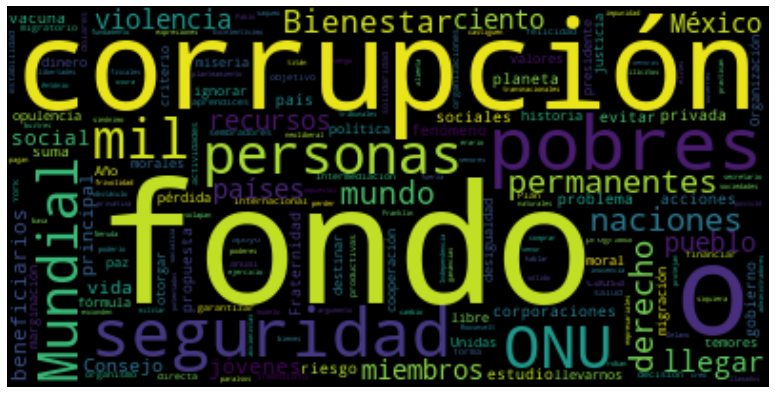

In [15]:
# Actualizamos palabras a mano
palabras_paro.update([
  "y", "a"
])

# Genera la nube de palabras
wc = wordcloud.WordCloud(
    stopwords=palabras_paro
).generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Un poco mejor, pero podemos ajustar mejor los tamaños de las letras y otros detalles

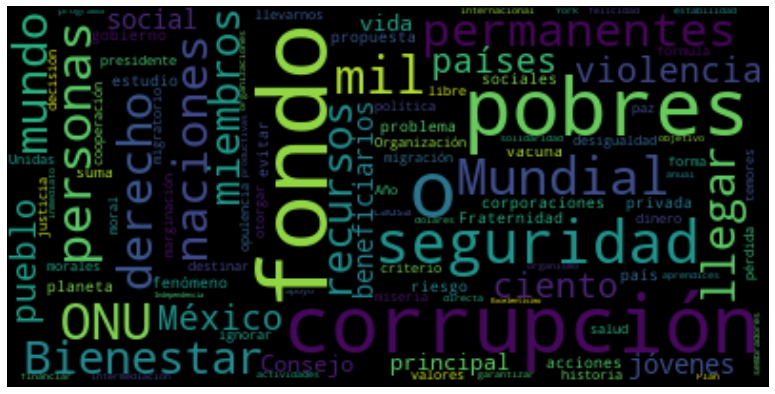

In [16]:
# Una mascara redonda de radio dado en pixeles
radio = 200
largo = int(1.2 * radio)
x, y = np.ogrid[:2*largo, :2*largo]
mascara_redonda = (x - largo) ** 2 + (y - largo) ** 2 > radio ** 2
mascara_redonda = 255 * mascara_redonda.astype(int)


# Genera la nube de palabras
wc = wordcloud.WordCloud(
    stopwords=palabras_paro,
    max_words=100,
    max_font_size=50,
    background_color="black",
    #mask= mask
).generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Si te gusta lo puedes guardad
wc.to_file("nube.png")

## Usando  `spacy` para extraer mejores características

Vamos ahora a utilizar spacy y su capacidad para tratar tokens de forma automñatica para extraer diferentes características importantes del informe y revisar como procesar texto con spacy.

Por ejemplo, vamos a ver que adjetivos utilizó el presidente en su discurso

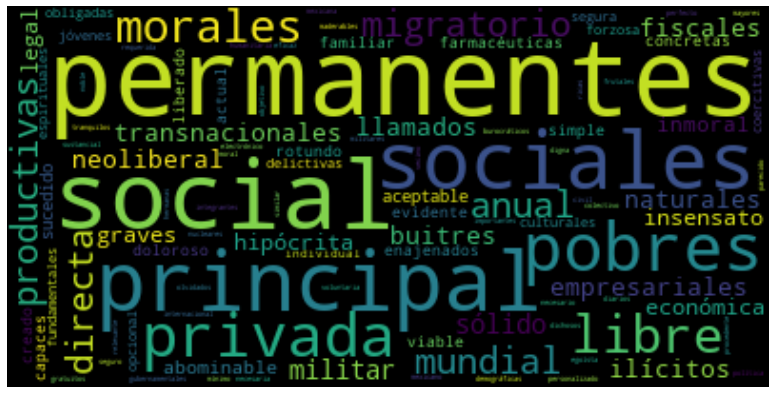

In [17]:
doc = nlp(texto)

palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.pos_ in ['ADJ']
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()



¿Y que verbos utilizó el presidente? ¿Se puede sacar alguna conclusión? ¿Cambia si se usan los verbos en infinitivo?

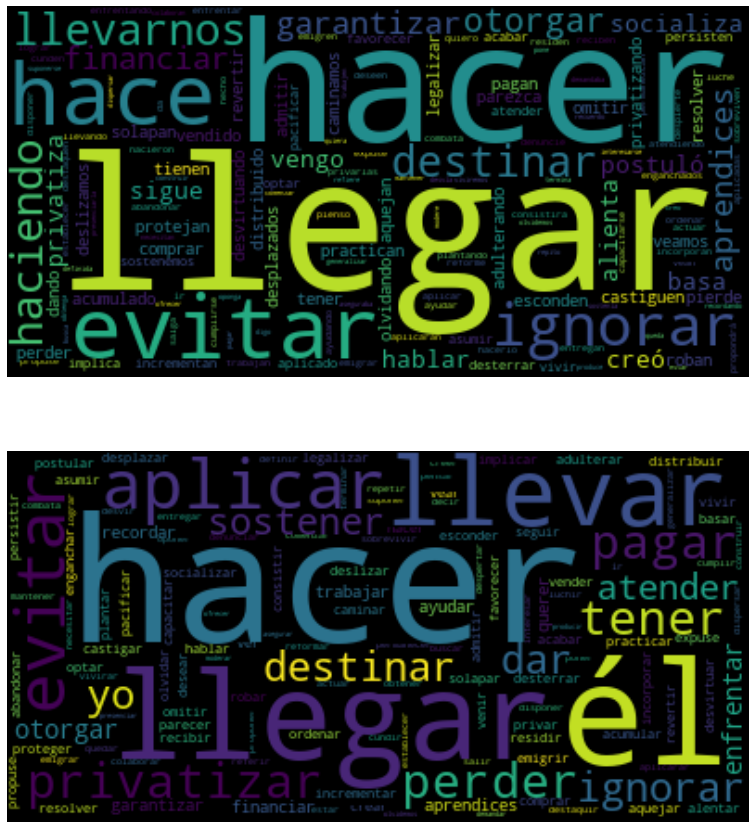

In [18]:
verbos = ' '.join(
  [token.norm_ for token in doc if token.pos_ in ['VERB']]
)

verbos_inf = ' '.join(
  [token.lemma_ for token in doc if token.pos_ in ['VERB']]
)


# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(verbos)
wc2 = wordcloud.WordCloud().generate(verbos_inf)

# Muestra la nube de palabras
plt.figure(figsize=(15, 15))
plt.subplot(2,1,1)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.show()

¿Y su usamos puros sustantivos?

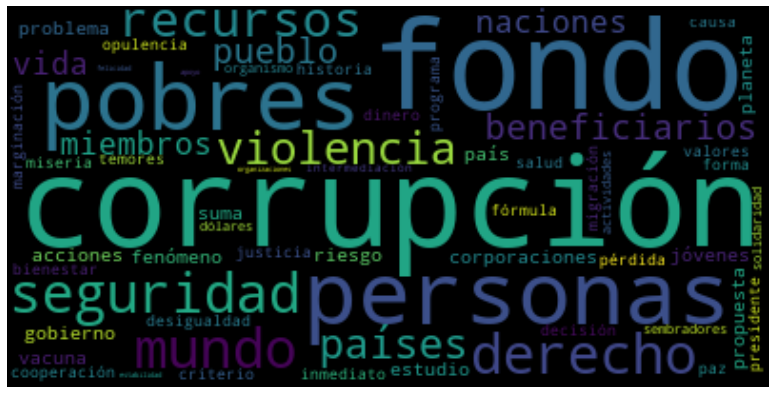

In [19]:
palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.pos_ in ['NOUN']
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()



¿Y por nombres propios?

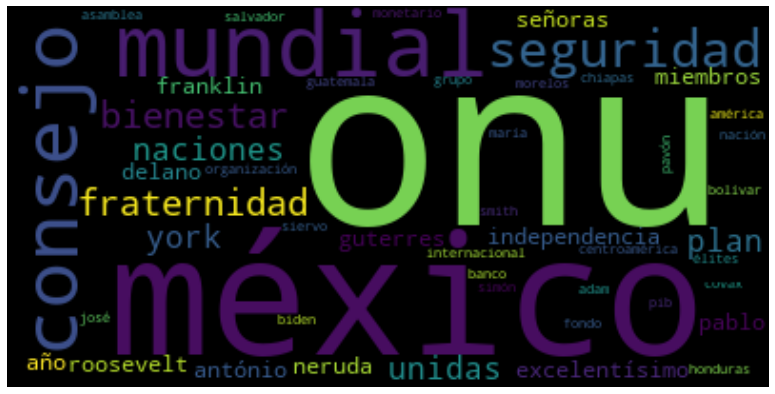

In [25]:
palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.pos_ in ['PROPN'] 
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


¿Y que tal si pudiermos ver los lugares que más mencionó? ¿Y las organizaciones que menciona?

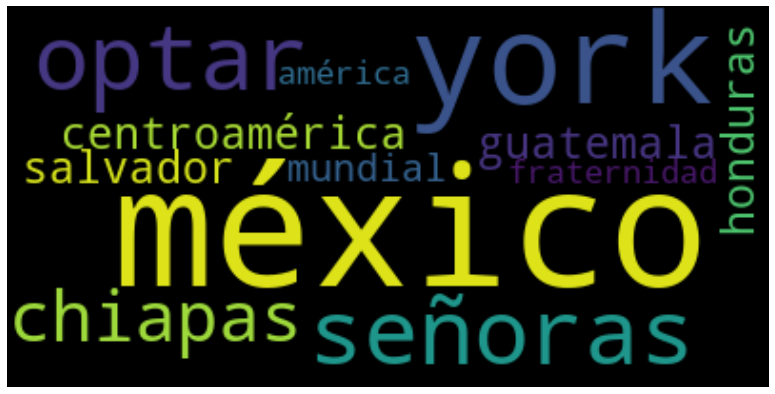

In [23]:
palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.ent_type_ == 'LOC' 
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


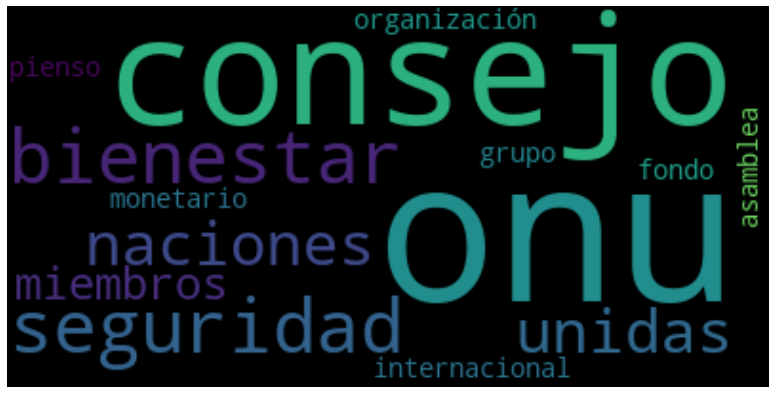

In [24]:
palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.ent_type_ == 'ORG' 
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()